In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
from sqlalchemy import create_engine

In [23]:
host = r'127.0.0.1' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'7205458456' 
port = r'5432' 
schema = r'cleaned'

In [24]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [25]:
query = f"SELECT * FROM {schema}.clean_df" 
ObesityData2 = pd.read_sql(query, db_conn)

In [26]:
ObesityData2 = ObesityData2.dropna()

In [27]:
print(ObesityData2.head())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0       Never   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

In [28]:
ObesityData2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2087 non-null   object 
 1   Age                             2087 non-null   float64
 2   Height                          2087 non-null   float64
 3   Weight                          2087 non-null   float64
 4   family_history_with_overweight  2087 non-null   object 
 5   FAVC                            2087 non-null   object 
 6   FCVC                            2087 non-null   float64
 7   NCP                             2087 non-null   float64
 8   CAEC                            2087 non-null   object 
 9   SMOKE                           2087 non-null   object 
 10  CH2O                            2087 non-null   float64
 11  SCC                             2087 non-null   object 
 12  FAF                             20

Analytical Question: What factors are most influential in classifying the level of obesity in individuals?

In [29]:
categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 
                       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']

ObesityData2_dummies = pd.get_dummies(ObesityData2, columns=categorical_columns, drop_first=False)

print(ObesityData2_dummies.head())



    Age  Height  Weight           NObeyesdad  Gender_Female  Gender_Male  \
0  21.0    1.62    64.0        Normal_Weight              1            0   
1  21.0    1.52    56.0        Normal_Weight              1            0   
2  23.0    1.80    77.0        Normal_Weight              0            1   
3  27.0    1.80    87.0   Overweight_Level_I              0            1   
4  22.0    1.78    89.8  Overweight_Level_II              0            1   

   family_history_with_overweight_no  family_history_with_overweight_yes  \
0                                  0                                   1   
1                                  0                                   1   
2                                  0                                   1   
3                                  1                                   0   
4                                  1                                   0   

   FAVC_no  FAVC_yes  ...  TUE_2.0  CALC_Always  CALC_Frequently  CALC_Never  \
0     

### Create the new manual features

In [30]:
ObesityData2['BMI'] = ObesityData2['Weight'] / (ObesityData2['Height'] / 100) ** 2

New Feature: BMI: is a key factor in obesity classification and will provide the model with a metric directly related to the level of obesity.

In [31]:
print(ObesityData2['SCC'].unique())

['no' 'yes']


In [32]:
ObesityData2['SCC'] = ObesityData2['SCC'].map({'no': 0, 'yes': 1})

In [33]:
print(ObesityData2['SCC'].unique())

[0 1]


In [34]:
ObesityData2['Water_to_Calories_ratio'] = ObesityData2['CH2O'] / ObesityData2['SCC']

New Feature: Water_to_Calories_ratio: People who drink more water and watch their calories may be more health conscious, which has a direct relationship to obesity.

In [35]:
print(ObesityData2['CAEC'].unique())


['Sometimes' 'Frequently' 'Always' 'no']


In [36]:
ObesityData2['CAEC'] = ObesityData2['CAEC'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

In [37]:
ObesityData2['CAEC_IMC_Relationship'] = ObesityData2['CAEC'] * ObesityData2['BMI']

New Feauture: CAEC_IMC_Relationship: This new feature could help detect whether people who tend to snack between meals and have a high BMI are more likely to be obese.

In [38]:
ObesityData2['SMOKE'] = ObesityData2['SMOKE'].replace({'yes': 1, 'no': 0})

In [43]:
print(ObesityData2['SMOKE'].unique())

[0 1]


In [39]:
ObesityData2['Alcohol_Smoke_Ratio'] = ObesityData2['TUE'] / ObesityData2['SMOKE']

New Feature: Alcohol_Smoke_Ratio: This ratio can give us an idea of ​​how alcohol consumption is related to the tendency to smoke and, in turn, to obesity factors.

In [44]:
ObesityData2['Alcohol_Smoke_Ratio'].fillna(ObesityData2['Alcohol_Smoke_Ratio'].mean(), inplace=True)

In [45]:
ObesityData2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2087 non-null   object 
 1   Age                             2087 non-null   float64
 2   Height                          2087 non-null   float64
 3   Weight                          2087 non-null   float64
 4   family_history_with_overweight  2087 non-null   object 
 5   FAVC                            2087 non-null   object 
 6   FCVC                            2087 non-null   float64
 7   NCP                             2087 non-null   float64
 8   CAEC                            2087 non-null   int64  
 9   SMOKE                           2087 non-null   int64  
 10  CH2O                            2087 non-null   float64
 11  SCC                             2087 non-null   int64  
 12  FAF                             20

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [49]:
label_encoder = LabelEncoder()
ObesityData2['Gender'] = label_encoder.fit_transform(ObesityData2['Gender'])
ObesityData2['family_history_with_overweight'] = label_encoder.fit_transform(ObesityData2['family_history_with_overweight'])
ObesityData2['FAVC'] = label_encoder.fit_transform(ObesityData2['FAVC'])
ObesityData2['CALC'] = label_encoder.fit_transform(ObesityData2['CALC'])
ObesityData2['MTRANS'] = label_encoder.fit_transform(ObesityData2['MTRANS'])
ObesityData2['NObeyesdad'] = label_encoder.fit_transform(ObesityData2['NObeyesdad'])

In [51]:
X = ObesityData2.drop(columns=['NObeyesdad'])
y = ObesityData2['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
import numpy as np

X_train.replace([np.inf, -np.inf], 0, inplace=True)

X_test.replace([np.inf, -np.inf], 0, inplace=True)


In [57]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

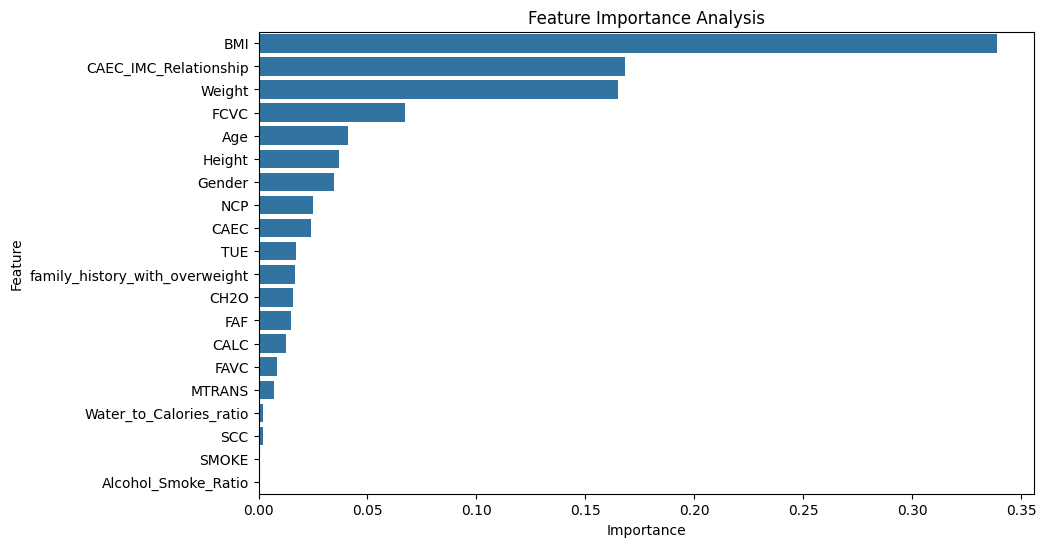

In [58]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance Analysis")
plt.show()

cross_val_score: to obtain the average precision and standard deviation

In [60]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Average accuracy of cross-validation: {cv_scores.mean()}")
print(f"Standard deviation of cross-validation: {cv_scores.std()}")


Average accuracy of cross-validation: 0.9838233443023864
Standard deviation of cross-validation: 0.004058663099070925


Analysis:

Analytical Question: 
What factors are most important in classifying the level of obesity in individuals?
The goal was to explore factors that contribute to obesity and use them to create a ML model.

Features Created: I created 4 new features to help with the analysis:

1. BMI (Body Mass Index): A key measure of obesity based on height and weight.
2. Water_Calories_Ratio: Measures the relationship between water intake and calories consumed, as both can affect weight.
3. CAEC_IMC_Relationship: Combines eating habits CAEC (Do you eat any food between meals?) with BMI to better understand how eating affects weight.
4. Alcohol_Smoke_Ratio: Examines the relationship between alcohol consumption and smoking, as both can influence obesity.
These features were chosen because they are directly related to factors that impact obesity, like diet and lifestyle.

Performance: The models performance was very good:

Average Accuracy: 98.38%
Standard Deviation: 0.41%
This shows the model is stable and performs well on different data sets.

Feature Importance: The most important features for predicting obesity were:

BMI
CAEC_IMC_Relationship
Weight
FCVC (Do you usually eat vegetables in your meals?)
These results make sense since these factors are closely linked to obesity.

Concerns with Overfitting/Redundancy: The model showed no major signs of overfitting, as the accuracy was stable. 

Additional Evaluation: Besides feature importance, I also used cross-validation to check the model's reliability. This confirmed that the model performs well and is stable.

Conclusion: The new features helped improve the model, and it performed excellently. Using different evaluation tools is important to getting a more complete picture of the model’s performance and reliability